## Henon Heiles: Reversible Polynomial Henon Maps
### Cambia i nomi ai plt.savefig()

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb

### Import Training Dataset

In [3]:
file = open("x_train_HH_E00833.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

Ty = []
Tydot = []

read_y = open("x_train_HH_E00833.txt", "r")
read_ydot = open("y_train_HH_E00833.txt", "r")


for i in range(line_count):
    Ty.append(float(read_y.readline()))
    Tydot.append(float(read_ydot.readline()))

read_y.close()
read_ydot.close()

print("Number of points: ", len(Ty))

FileNotFoundError: [Errno 2] No such file or directory: 'x_train_HH.txt'

NameError: name 'Ty' is not defined

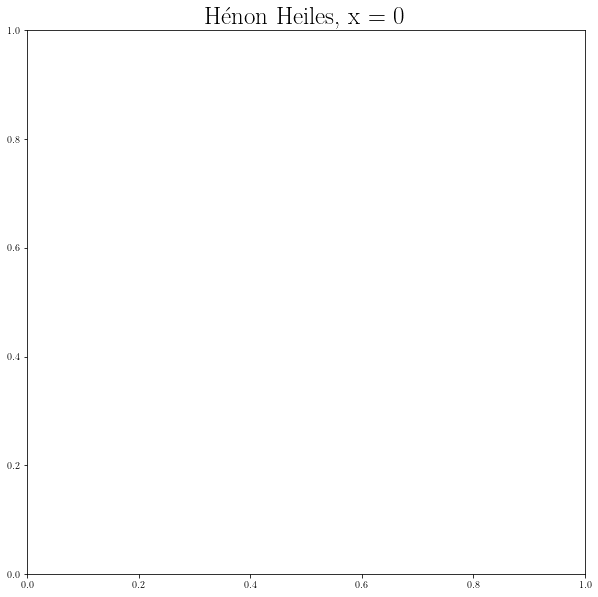

In [4]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'H\'enon Heiles, x = 0', fontsize = 25)
plt.scatter(Ty,Tydot, color = 'b', label = 'target', linewidth = 1, s=2)
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 15, loc = 'upper right')
plt.show()

### Training Dataset

In [56]:
X_train = [np.array([Ty[i],Tydot[i]]) for i in range(len(Ty)-1)]
Y_train = [np.array([Ty[i],Tydot[i]]) for i in range(1,len(Ty))]

In [57]:
# TRAINING SET

x_train = np.array(X_train)
x_train = x_train.astype(np.float32)

y_train = np.array(Y_train)
y_train = y_train.astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.batch(10000)

train_dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

-----------------------------------------
-----------------------------------------
-----------------------------------------

### Custom layer

In [5]:
class H(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(5,),
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
        trainable = True
        )

    def call(self, x, inverse):
        
        if inverse == 0:
        
            L0 = tf.concat([[[1., 0.],[0., 0.]]], 0)
            L10 = tf.concat([[[0., 0.],[0., -1]]], 0)

            L1 = tf.concat([[[0., 0.],[0., self.w[0]]]], 0)
            L2 = tf.concat([[[0., 0.],[0., self.w[1]]]], 0)
            L3 = tf.concat([[[0., 0.],[0., self.w[2]]]], 0)
            L4 = tf.concat([[[0., 0.],[0., self.w[3]]]], 0)
            #L5 = tf.concat([[[0., 0.],[0., self.w[4]]]], 0)


            x̄ = tf.reverse(x, [1])
            b = tf.constant([[0., 1.]])

            return tf.linalg.matvec(L0, x̄) + tf.linalg.matvec(L10, x̄) + tf.linalg.matvec(L1, b) + tf.linalg.matvec(L2, x) + tf.linalg.matvec(L3, x)*x + tf.linalg.matvec(L4, x)*x*x #+ tf.linalg.matvec(L5, x)*x*x*x
        
        else:
            
            L0 = tf.concat([[[0., 0.],[0., 1.]]], 0)
            L10 = tf.concat([[[-1., 0.],[0., 0.]]], 0)

            L1 = tf.concat([[[self.w[0], 0.],[0., 0.]]], 0)
            L2 = tf.concat([[[self.w[1], 0.],[0., 0.]]], 0)
            L3 = tf.concat([[[self.w[2], 0.],[0., 0.]]], 0)
            L4 = tf.concat([[[self.w[3], 0.],[0., 0.]]], 0)
            #L5 = tf.concat([[[self.w[4], 0.],[0., 0.]]], 0)
            
            
            x̄ = tf.reverse(x, [1])
            b = tf.constant([[1., 0.]])
            
            return tf.linalg.matvec(L0, x̄) + tf.linalg.matvec(L10, x̄) + tf.linalg.matvec(L1, b) + tf.linalg.matvec(L2, x) + tf.linalg.matvec(L3, x)*x + tf.linalg.matvec(L4, x)*x*x #+ tf.linalg.matvec(L5, x)*x*x*x

### Model

In [6]:
class Henon(keras.Model):
    
    def __init__(self, N):
        
        super().__init__()
        
        self.Hs = []
        for i in range(N):
            self.Hs.append(H())


    def call(self, input_tensor):
    
        boom = input_tensor
        for i in range(len(self.Hs)):
            boom = self.Hs[i](boom, 0)
            
        boom = boom*tf.constant([1., -1.])
        
        for i in range(1, len(self.Hs)):
            boom = self.Hs[-i](boom, 1)

        boom = self.Hs[0](boom, 1)*tf.constant([1., -1.])
        
        return boom

In [7]:
model = Henon(8)

## Training

In [61]:
# DECAYING LEARNING RATE

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.002)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [62]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [63]:
#wandb.init()
start_time = time.time()
history = model.fit(train_dataset, epochs = 10, callbacks=[callback], verbose=1)
print("running time : %s seconds" % (time.time() - start_time))

Epoch 1/10
147/147 [==============================] - 5s 35ms/step - loss: 0.2067 - accuracy: 0.4667
Epoch 2/10
147/147 [==============================] - 6s 39ms/step - loss: 0.1438 - accuracy: 0.6459
Epoch 3/10
147/147 [==============================] - 17s 118ms/step - loss: 1228722432.0000 - accuracy: 0.6982
Epoch 4/10
147/147 [==============================] - 6s 41ms/step - loss: 0.1644 - accuracy: 0.7391
Epoch 5/10
147/147 [==============================] - 6s 38ms/step - loss: 0.1681 - accuracy: 0.7379
Epoch 6/10
147/147 [==============================] - 5s 37ms/step - loss: 0.1681 - accuracy: 0.7379
Epoch 7/10
147/147 [==============================] - 5s 37ms/step - loss: 0.1681 - accuracy: 0.7379
Epoch 8/10
147/147 [==============================] - 5s 37ms/step - loss: 0.1681 - accuracy: 0.7379
Epoch 9/10
147/147 [==============================] - 5s 37ms/step - loss: 0.1681 - accuracy: 0.7379
Epoch 10/10
147/147 [==============================] - 5s 36ms/step - loss: 0.16

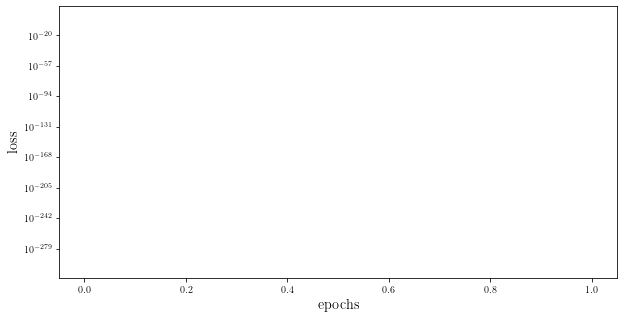

In [45]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.savefig("loss_Henon_E01667")

# Tests

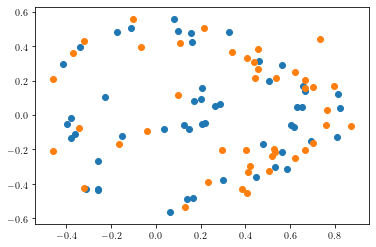

In [137]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 30)

x = model(tf.constant([[Ty[0], Tydot[0]]]))
xx = [x[0][0].numpy()]
yy = [x[0][1].numpy()]


for i in range(19):
    x = model(x)
    xx.append(x[0][0].numpy())
    yy.append(x[0][1].numpy())

plt.plot(xx, yy, color='r')

plt.scatter(xx[-1], yy[-1], label=r'$\mathcal{T}^{20}(x,y)$', marker = 'o', color='r', s=35)
plt.scatter(xx[-1], -yy[-1], label=r'$R\mathcal{T}^{20}(x,y)$', marker = 'o', color='b', s=35)


x = model(tf.constant([[xx[-1], -yy[-1]]]))
xx = [xx[-1]]
yy = [-yy[-1]]
xx.append(x[0][0].numpy())
yy.append(x[0][1].numpy())

for i in range(19):
    x = model(x)
    xx.append(x[0][0].numpy())
    yy.append(x[0][1].numpy())

plt.plot(xx,yy, color='b')
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25, loc = 'upper right')
#plt.savefig("reversible_E0125")
plt.show()

In [ ]:
test = model(x_train)

In [ ]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Composition of H\'enon Maps', fontsize = 30)
plt.scatter(Ty,Tydot, color = "b", label = r'target, $x$', linewidth = 1, s=2)
plt.scatter([test[i][0].numpy() for i in range(len(x_train))], [test[i][1].numpy() for i in range(len(x_train))], color = "r", label = r'$\mathcal{T}^{2}(x)$, learned', linewidth = 1, s=2)
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25, loc = 'lower right')
plt.savefig("Iterations_Henon_E0125")
plt.show()